# River Discharge

In [1]:
import pandas as pd
import pydaymet as daymet
import pygeohydro as gh
import xarray as xr
from pygeohydro import NWIS, plot

In [2]:
_ = xr.set_options(display_expand_attrs=False)

We can explore the available NWIS stations within a bounding box using ``interactive_map`` function. It returns an interactive map and by clicking on an station some of the most important properties of stations are shown so you can decide which station(s) to choose from.

In [3]:
bbox = (-69.5, 45, -69, 45.5)

In [4]:
nwis_kwds = {"hasDataTypeCd": "dv", "outputDataTypeCd": "dv", "parameterCd": "00060"}
gh.interactive_map(bbox, nwis_kwds=nwis_kwds)

/Users/tchegini/.local/apps/mambaforge/envs/hyriver-dev/lib/python3.10/site-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


We can get more information about these stations using the `get_info` function from `NWIS` class.

In [5]:
nwis = NWIS()
query = {
    "bBox": ",".join(f"{b:.06f}" for b in bbox),
    "hasDataTypeCd": "dv",
    "outputDataTypeCd": "dv",
}
info_box = nwis.get_info(query)

Now, let's select all the stations that their daily mean streamflow data are available between 2000-01-01 and 2010-12-31.

In [6]:
dates = ("2000-01-01", "2010-12-31")
stations = info_box[
    (info_box.begin_date <= dates[0]) & (info_box.end_date >= dates[1])
].site_no.tolist()

One of the useful information in the database in Hydro-Climatic Data Network - 2009 (HCDN-2009) flag. This flag shows whether the station is natural (True) or affected by human activities (False). If an station is not available in the HCDN dataset `None` is returned.

In [7]:
query = {
    "site": ",".join(stations),
    "hasDataTypeCd": "dv",
    "outputDataTypeCd": "dv",
}
info = nwis.get_info(query, expanded=True)
info.set_index("site_no").hcdn_2009

site_no
01031450           False
01031500            True
01031500            True
01031500            True
01031500            True
451031069185301     None
451105069270801     None
Name: hcdn_2009, dtype: object

We can get the daily mean streamflow for these stations using the ``get_streamflow`` function. This function has a flag to return the data mm/day rather than the default `cms` which is useful for hydrolgy models and plotting hydrologic signatures.

In [8]:
qobs = nwis.get_streamflow(stations, dates, mmd=False)

By default, `get_streamflow` returns a `pandas.DataFrame` that has an `attrs` method containing metadata for all the stations.

Moreover, we can get the same data as `xarray.Dataset` as follows:

In [9]:
qobs_ds = nwis.get_streamflow(stations, dates, mmd=False, to_xarray=True)
qobs_ds

<xarray.Dataset>
Dimensions:       (time: 4018, station_id: 2)
Coordinates:
  * time          (time) datetime64[ns] 2000-01-01T05:00:00 ... 2010-12-31T05...
  * station_id    (station_id) object 'USGS-01031450' 'USGS-01031500'
Data variables:
    discharge     (time, station_id) float64 2.039 5.975 1.841 ... 4.389 12.6
    station_nm    (station_id) <U44 'Kingsbury Stream at Abbot Village, Maine...
    dec_lat_va    (station_id) float64 45.18 45.17
    dec_long_va   (station_id) float64 -69.45 -69.31
    alt_va        (station_id) float64 423.0 358.5
    alt_acy_va    (station_id) float64 0.01 0.01
    alt_datum_cd  (station_id) <U6 'NGVD29' 'NGVD29'
    huc_cd        (station_id) <U8 '01020004' '01020004'
    begin_date    (station_id) <U10 '1997-07-26' '1902-10-01'
    end_date      (station_id) <U10 '2022-01-11' '2022-01-11'
Attributes: (1)

Then we can use the ``signatures`` function to plot hydrologic signatures of the streamflow. Note that the input time series should be in mm/day. This function has argument, `output`, for saving the plot as a `png` file.

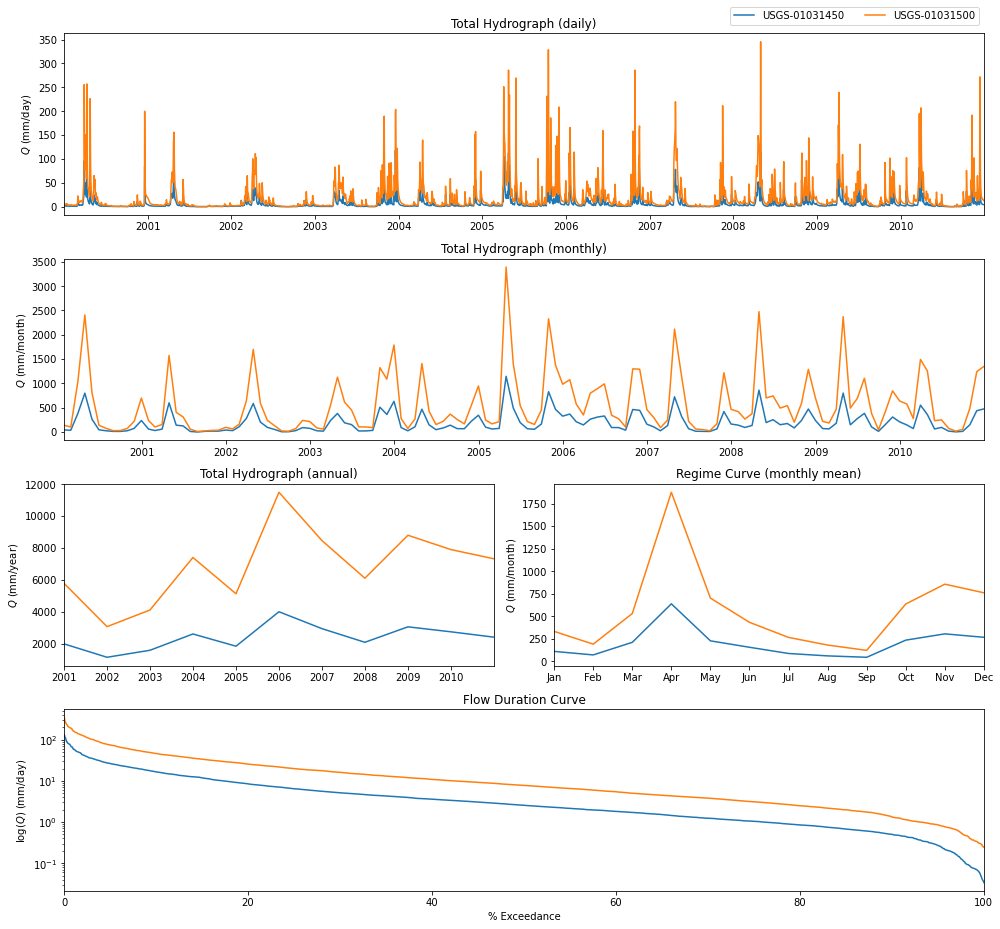

In [10]:
plot.signatures(qobs, output="_static/example_plots_signatures.png")

This function also can show precipitation data as a bar plot. Let's use [PyDaymet](https://github.com/cheginit/pydaymet) to get the precipitation at the NWIS stations location.

In [11]:
sid = "01031500"
coords = tuple(info[info.site_no == sid][["dec_long_va", "dec_lat_va"]].to_numpy()[0])
prcp = daymet.get_bycoords(coords, dates, variables="prcp", ssl=False)
qobs.index = pd.to_datetime(qobs.index.strftime("%Y-%m-%d"))

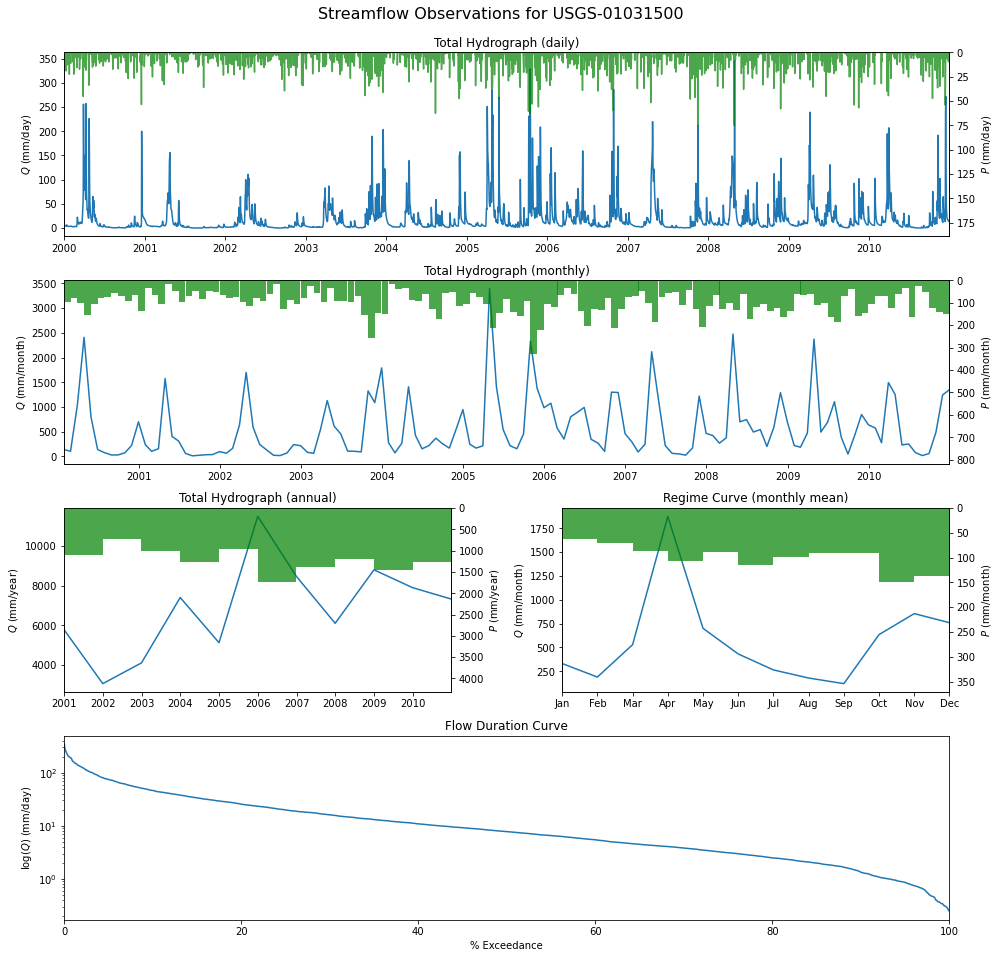

In [12]:
plot.signatures(qobs[f"USGS-{sid}"], prcp, title=f"Streamflow Observations for USGS-{sid}")

We can also get instantaneous streamflow data using `get_streamflow`. This method assumes that the input dates are in UTC time zone and returns the data in UTC time zone as well.

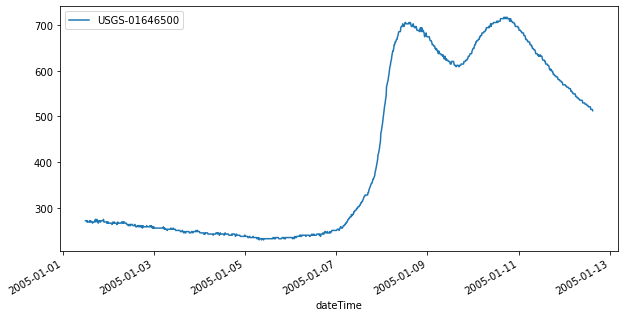

In [13]:
qobs = nwis.get_streamflow("01646500", ("2005-01-01 12:00", "2005-01-12 15:00"), freq="iv")
_ = qobs.plot(figsize=(10, 5))